In [1]:
import pandas as pd
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
import pymysql
from datetime import datetime
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
daterange = pd.date_range(start='20151101',periods=17,freq='M') 
daterange = list(x.strftime('%Y-%m') for x in daterange)
data = pd.read_csv('hupai.csv',header = None,index_col=0)
data.columns = daterange
data.index.name = 'Time'
data.tail()

,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03
Time,,,,,,,,,,,,,,,,,
11:29:56,84400,84200,82200,83100,83000,84800,84700,84300,87000,86500,86100,88100,88400,88000,87200,88000,87600
11:29:57,84500,84300,82200,83100,83000,84800,84800,84300,87100,86600,86200,88100,88500,88100,87300,88100,87700
11:29:58,84500,84400,82200,83200,83000,84900,84900,84300,87100,86700,86200,88100,88500,88100,87400,88100,87700
11:29:59,84600,84400,82200,83200,83100,85000,84900,84300,87200,86800,86300,88200,88600,88200,87500,88200,87800
11:30:00,84600,84500,82200,83200,83100,85100,85000,84400,87200,86900,86500,88300,88600,88300,87600,88200,87800


In [3]:
#旧方法测试
def old_test(BaseTime,AddPrice,PushTime,Delay,data):
    results = []
    marks = []    
    for i in range(1,len(data.columns)):  
        result = 0 
        mark = 'Fail'
        BasePrice = data.ix[BaseTime][i]
        PushPrice = BasePrice + AddPrice
        DealLowPrice = data.ix[60][i]
        if PushPrice >= DealLowPrice:
            if PushPrice < data.ix[PushTime+Delay][i] + 300:
                if PushPrice == DealLowPrice:
                    result = 1
                    mark = 'LowPriceLine'
                else:
                    result = 1
                    mark = 'Success'
            else:
                mark = 'HighPrice'
        results.append(result)
        marks.append(mark)
    return ({'BaseTime':BaseTime,'AddPrice':AddPrice,'PushTimeDelay':PushTimeDelay,'result':results,
             'mark':marks})

In [4]:
#新方法测试
def new_test(BaseTime,AddPrice,PushTiming,Delay,data):
    date = []
    results = []
    marks = []
    PushTimes = []
    for i in range(1,len(data.columns)):
        global PushTime
        result = 0
        mark = 'Fail'
        BasePrice = data.ix[BaseTime][i]
        PushPrice = BasePrice + AddPrice
        DealLowPrice = data.ix[60][i]
        try:
            PushTime = data[data.ix[:,i] == PushPrice - PushTiming].index[0]
        except IndexError:
            PushTime = 57
        if PushTime > 57:
            PushTime = 57    
        if PushTime+Delay < 60:           
            if PushPrice >= DealLowPrice:
                if PushPrice -  data.ix[PushTime+Delay][i] <= 300:
                    if PushPrice == DealLowPrice:
                        result = 1
                        mark = 'LowPriceLine'
                    else:
                        result = 1
                        mark = 'Success'
                else:
                    mark = 'HighPrice'
        else:
            mark = 'OutTime'
        date.append(data.columns[i])
        results.append(result)
        marks.append(mark)
        PushTimes.append(PushTime + Delay)
    return ({'date':date,
             'BaseTime':BaseTime,
             'AddPrice':AddPrice,
             'PushTiming':PushTiming,
             'Delay':Delay,
             'result':results,
             'mark':marks,
             'Push':PushTimes})

In [5]:
x = []
for BaseTime in range(40,54):
    for AddPrice in range(3,13):
        for Delay in range(0,5):
            datas = []
            datas.append(BaseTime)
            datas.append(AddPrice*100)
            datas.append(400)
            datas.append(Delay)
            x.append(datas)

In [6]:
results = DataFrame()
for y in x:
    BaseTime=y[0]
    AddPrice=y[1]
    PushTiming=y[2]
    Delay=y[3]
    result = DataFrame(new_test(BaseTime,AddPrice,PushTiming,Delay,data))
    results = pd.concat([results,result])

In [7]:
temp = results['mark'].groupby([results.BaseTime,results.AddPrice,results.mark]).count()
temp1 = temp.unstack().fillna('')

In [8]:
temp2 = results.mark.groupby([results.BaseTime,results.mark]).count().unstack().fillna(0)

In [9]:
temp1 = results.result.groupby([results.BaseTime,results.AddPrice]).sum().unstack()

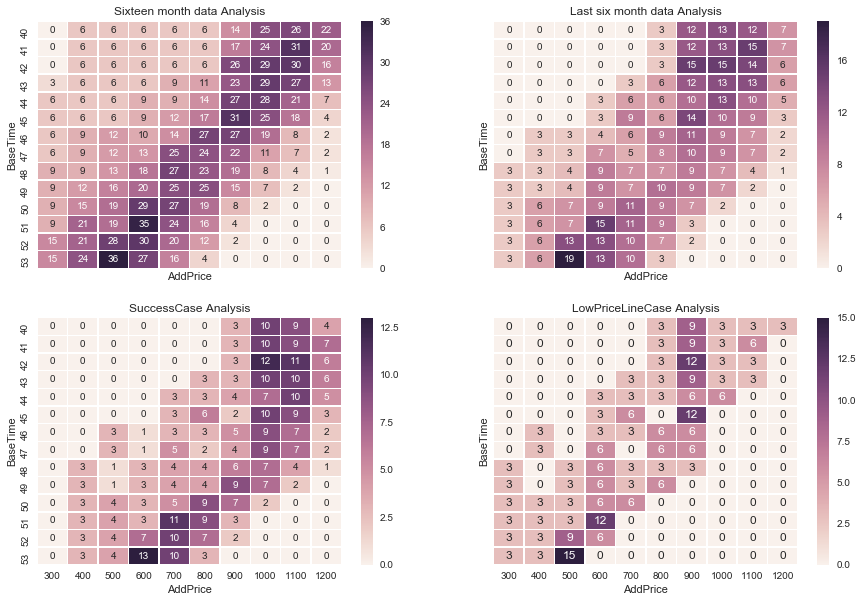

In [10]:
f,axes = plt.subplots(2,2,figsize=(15,10),sharex=True,sharey=True)


#sixteen month data Analysis
sns.heatmap(temp1, annot=True,fmt="d", linewidths=.5,ax=axes[0,0])
axes[0,0].set(title='Sixteen month data Analysis')

#Last six month data Analysis
results2 = results[results.date >= '2016-09']
temp2 = results2.result.groupby([results2.BaseTime,results2.AddPrice]).sum().unstack()
sns.heatmap(temp2, annot=True, fmt="d", linewidths=.5,ax=axes[0,1])
axes[0,1].set(title='Last six month data Analysis')

#SuccessCase Analysis
SuccessCase = results2[results2.mark == 'Success']
temp3 = SuccessCase.result.groupby([SuccessCase.BaseTime,SuccessCase.AddPrice]).sum().unstack().fillna(0)
t= np.zeros(14)
temp3.insert(loc=0,value=t,column='300')
temp3 = temp3.astype(int)

sns.heatmap(temp3, annot=True, fmt="d", linewidths=.5,ax=axes[1,0])
axes[1,0].set(title='SuccessCase Analysis')

#LowPriceLineCase Analysis
sns.set(style="white")
LowPriceLineCase = results2[results2.mark == 'LowPriceLine']
temp4 = LowPriceLineCase.result.groupby([LowPriceLineCase.BaseTime,LowPriceLineCase.AddPrice]).sum().unstack().fillna(0)
temp4 = temp4.astype(int)
sns.heatmap(temp4, annot=True, fmt="d", linewidths=.5,ax=axes[1,1])
axes[1,1].set(title='LowPriceLineCase Analysis')



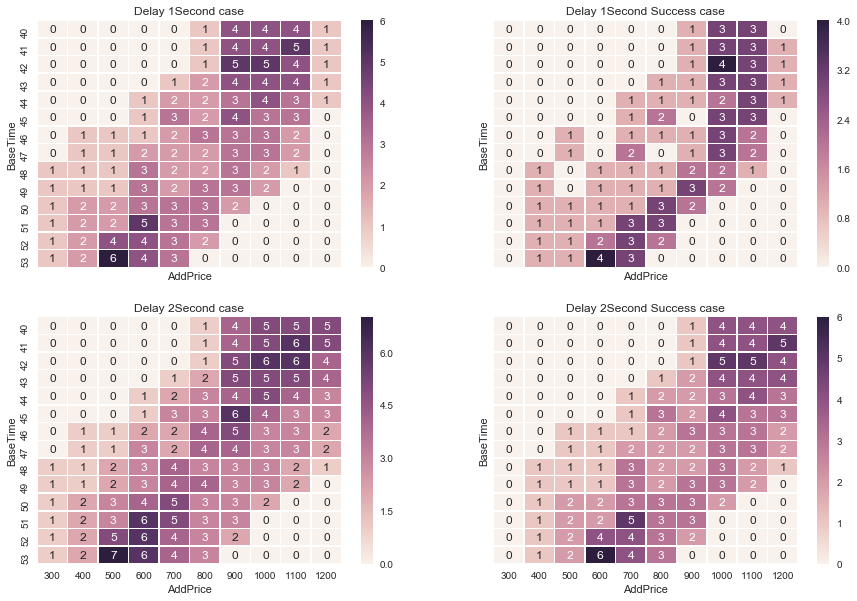

In [11]:
f,axes = plt.subplots(2,2,figsize=(15,10),sharex=True,sharey=True)

#Delay 1Second case
onesecond_case = results2[results2.Delay == 1]
temp5 = onesecond_case.result.groupby([onesecond_case.BaseTime,onesecond_case.AddPrice]).sum().unstack().fillna(0)
sns.heatmap(temp5, annot=True,fmt="d", linewidths=.5,ax=axes[0,0])
axes[0,0].set(title='Delay 1Second case')

onesecond_success_case = onesecond_case[onesecond_case.mark == 'Success']
temp6 = onesecond_success_case.result.groupby([onesecond_success_case.BaseTime,onesecond_success_case.AddPrice]).sum().unstack().fillna(0)
t= np.zeros(14)
temp6.insert(loc=0,value=t,column='300')
temp6 = temp6.astype(int)
sns.heatmap(temp6, annot=True,fmt="d", linewidths=.5,ax=axes[0,1])
axes[0,1].set(title='Delay 1Second Success case')
#Delay 2Second case
twosecond_case = results2[results2.Delay == 2]
temp7 = twosecond_case.result.groupby([twosecond_case.BaseTime,twosecond_case.AddPrice]).sum().unstack().fillna(0)
sns.heatmap(temp7, annot=True,fmt="d", linewidths=.5,ax=axes[1,0])
axes[1,0].set(title='Delay 2Second case')

twosecond_success_case = twosecond_case[twosecond_case.mark == 'Success']
temp8 = twosecond_success_case.result.groupby([twosecond_success_case.BaseTime,twosecond_success_case.AddPrice]).sum().unstack().fillna(0)
t= np.zeros(14)
temp8.insert(loc=0,value=t,column='300')
temp8 = temp8.astype(int)
sns.heatmap(temp8, annot=True,fmt="d", linewidths=.5,ax=axes[1,1])
axes[1,1].set(title='Delay 2Second Success case')


In [12]:
results.to_csv('results.csv')